# Applying the data_block API

In [29]:
from fastai import *
from fastai.vision import *

In [37]:
path = Path('data/aircrafts')

In [44]:
path.ls()
# (path/'train').ls()
# (path/'test').ls()

[PosixPath('data/aircrafts/valid'),
 PosixPath('data/aircrafts/train'),
 PosixPath('data/aircrafts/.ipynb_checkpoints')]

**Transformations**  
We can get a lot more specific with this. For example, for satellite images you can use  
`planet_tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)`

In [45]:
tfms = get_transforms(do_flip=False)

In [46]:
data = (ImageList.from_folder(path) #Where to find the data? -> in path and its subfolders
        .split_by_folder()              #How to split in train/valid? -> use the folders
        .label_from_folder()            #How to label? -> depending on the folder of the filenames
        .add_test_folder()              #Optionally add a test set (here default name is test)
        .transform(tfms, size=64)       #Data augmentation? -> use tfms with a size of 64
        .databunch())                   #Finally? -> use the defaults for conversion to ImageDataBunch

Alternatively, split by random instead of by folder using split_by_rand_pct()

In [55]:
data = (ImageList.from_folder(path) #Where to find the data? -> in planet 'train' folder
        .split_by_rand_pct() #How to split in train/valid? -> randomly with the default 20% in valid
        .label_from_folder() #How to label?
        .transform(tfms, size=64) #Data augmentation? -> use tfms with a size of 128
        .databunch())             #Finally -> use the defaults for conversion to databunch

## View data

Look at the data from the created databunch

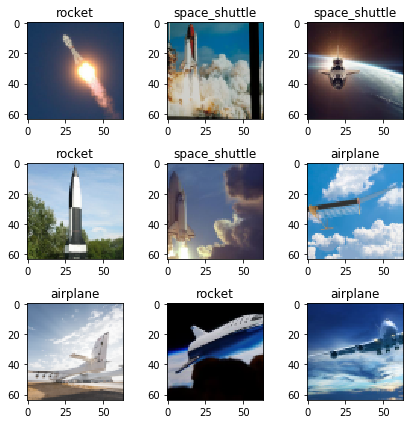

In [56]:
data.show_batch(3, figsize=(6,6), hide_axis=False)

In [49]:
data.c

3

Classes are inferred from folder names

In [57]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)
# data.valid_ds.classes
# data.train_ds.classes

(['airplane', 'rocket', 'space_shuttle'], 3, 515, 128)

## View data

In [ ]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['airplane', 'rocket', 'space_shuttle'], 3, 515, 128)

## Train model

In [17]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

/opt/anaconda3/lib/python3.7/site-packages/fastai/vision/learner.py:106: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")


In [18]:
learn.fit_one_cycle(6)

epoch,train_loss,valid_loss,error_rate,time
0,1.234131,0.726770,0.324561,00:05
1,0.867780,0.407293,0.166667,00:04
2,0.667005,0.316727,0.105263,00:03
3,0.539491,0.302270,0.087719,00:03
4,0.463153,0.303918,0.087719,00:03
5,0.416588,0.309489,0.087719,00:04


In [19]:
learn.save('stage-1')

In [20]:
learn.unfreeze()

In [21]:
learn.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (460 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
space_shuttle,space_shuttle,space_shuttle,space_shuttle,space_shuttle
Path: data;

Valid: LabelList (114 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
rocket,space_shuttle,space_shuttle,rocket,rocket
Path: data;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-0

In [22]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


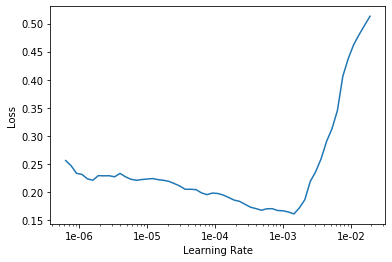

In [23]:
learn.recorder.plot()

In [24]:
learn.fit_one_cycle(2, max_lr=slice(3e-5,3e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.309087,0.846743,0.192982,00:04
1,0.296430,0.555406,0.131579,00:04


In [51]:
learn.save('stage-2')

## Interpretation

In [25]:
learn.load('stage-2');

In [26]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

In [27]:
doc(interp.plot_top_losses)

NameError: name 'doc' is not defined

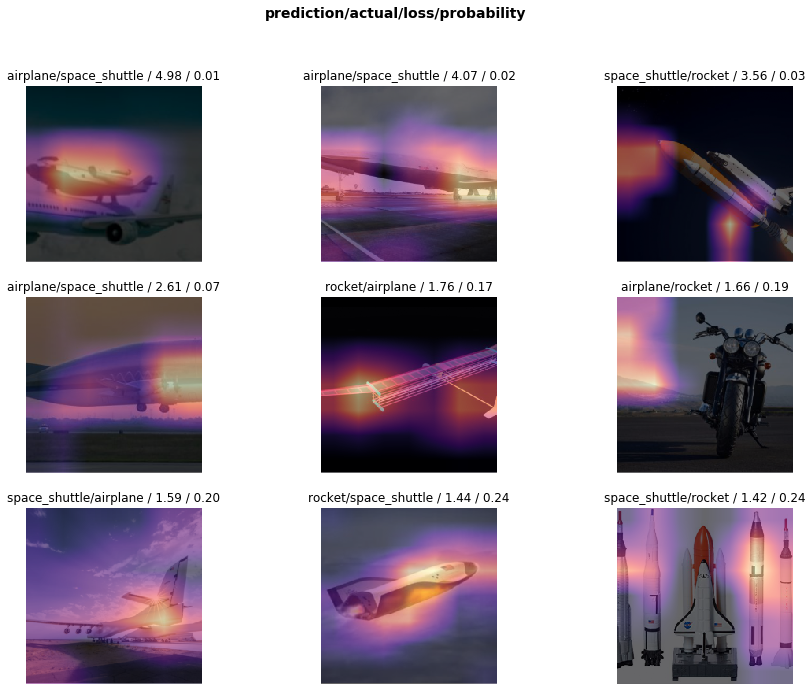

In [28]:
interp.plot_top_losses(9, figsize=(15,11))

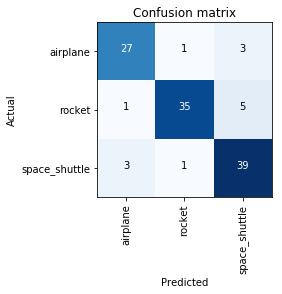

In [60]:
interp.plot_confusion_matrix()

In [74]:
interp.most_confused(min_val=2)

[('rocket', 'space_shuttle', 5),
 ('airplane', 'space_shuttle', 3),
 ('space_shuttle', 'airplane', 3)]

## Cleaning Up

Some of our top losses aren't due to bad performance by our model. There are images in our data set that shouldn't be.

Using the `ImageCleaner` widget from `fastai.widgets` we can prune our top losses, removing photos that don't belong.

In [61]:
from fastai.widgets import *

First we need to get the file paths from our top_losses. We can do this with `.from_toplosses`. We then feed the top losses indexes and corresponding dataset to `ImageCleaner`.

Notice that the widget will not delete images directly from disk but it will create a new csv file `cleaned.csv` from where you can create a new ImageDataBunch with the corrected labels to continue training your model.

In [62]:
ds, idxs = DatasetFormatter().from_toplosses(learn, ds_type=DatasetType.Valid)

In [66]:
ImageCleaner(ds, idxs, path)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

Flag photos for deletion by clicking 'Delete'. Then click 'Next Batch' to delete flagged photos and keep the rest in that row. `ImageCleaner` will show you a new row of images until there are no more to show. In this case, the widget will show you images until there are none left from `top_losses.ImageCleaner(ds, idxs)`

You can also find duplicates in your dataset and delete them! To do this, you need to run `.from_similars` to get the potential duplicates' ids and then run `ImageCleaner` with `duplicates=True`. The API works in a similar way as with misclassified images: just choose the ones you want to delete and click 'Next Batch' until there are no more images left.

In [67]:
ds, idxs = DatasetFormatter().from_similars(learn, ds_type=DatasetType.Valid)

Getting activations...


Computing similarities...


In [69]:
ImageCleaner(ds, idxs, path, duplicates=True)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

Remember to recreate your ImageDataBunch from your `cleaned.csv` to include the changes you made in your data!

## Putting your model in production

First thing first, let's export the content of our `Learner` object for production:

In [ ]:
learn.export()

This will create a file named 'export.pkl' in the directory where we were working that contains everything we need to deploy our model (the model, the weights but also some metadata like the classes or the transforms/normalization used).

You probably want to use CPU for inference, except at massive scale (and you almost certainly don't need to train in real-time). If you don't have a GPU that happens automatically. You can test your model on CPU like so:

In [ ]:
defaults.device = torch.device('cpu')

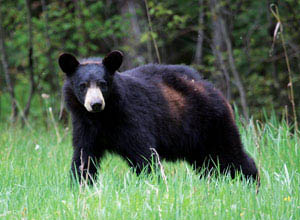

In [ ]:
img = open_image(path/'black'/'00000021.jpg')
img

We create our `Learner` in production enviromnent like this, jsut make sure that `path` contains the file 'export.pkl' from before.

In [ ]:
learn = load_learner(path)

In [ ]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category black

So you might create a route something like this ([thanks](https://github.com/simonw/cougar-or-not) to Simon Willison for the structure of this code):

```python
@app.route("/classify-url", methods=["GET"])
async def classify_url(request):
    bytes = await get_bytes(request.query_params["url"])
    img = open_image(BytesIO(bytes))
    _,_,losses = learner.predict(img)
    return JSONResponse({
        "predictions": sorted(
            zip(cat_learner.data.classes, map(float, losses)),
            key=lambda p: p[1],
            reverse=True
        )
    })
```

(This example is for the [Starlette](https://www.starlette.io/) web app toolkit.)

## Things that can go wrong

- Most of the time things will train fine with the defaults
- There's not much you really need to tune (despite what you've heard!)
- Most likely are
  - Learning rate
  - Number of epochs

### Learning rate (LR) too high

In [ ]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [ ]:
learn.fit_one_cycle(1, max_lr=0.5)

Total time: 00:13
epoch  train_loss  valid_loss  error_rate       
1      12.220007   1144188288.000000  0.765957    (00:13)



### Learning rate (LR) too low

In [ ]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

Previously we had this result:

```
Total time: 00:57
epoch  train_loss  valid_loss  error_rate
1      1.030236    0.179226    0.028369    (00:14)
2      0.561508    0.055464    0.014184    (00:13)
3      0.396103    0.053801    0.014184    (00:13)
4      0.316883    0.050197    0.021277    (00:15)
```

In [ ]:
learn.fit_one_cycle(5, max_lr=1e-5)

Total time: 01:07
epoch  train_loss  valid_loss  error_rate
1      1.349151    1.062807    0.609929    (00:13)
2      1.373262    1.045115    0.546099    (00:13)
3      1.346169    1.006288    0.468085    (00:13)
4      1.334486    0.978713    0.453901    (00:13)
5      1.320978    0.978108    0.446809    (00:13)



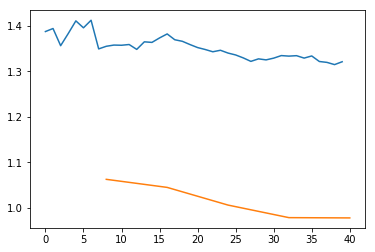

In [ ]:
learn.recorder.plot_losses()

As well as taking a really long time, it's getting too many looks at each image, so may overfit.

### Too few epochs

In [ ]:
learn = create_cnn(data, models.resnet34, metrics=error_rate, pretrained=False)

In [ ]:
learn.fit_one_cycle(1)

Total time: 00:14
epoch  train_loss  valid_loss  error_rate
1      0.602823    0.119616    0.049645    (00:14)



### Too many epochs

In [ ]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.9, bs=32, 
        ds_tfms=get_transforms(do_flip=False, max_rotate=0, max_zoom=1, max_lighting=0, max_warp=0
                              ),size=224, num_workers=4).normalize(imagenet_stats)

In [ ]:
learn = create_cnn(data, models.resnet50, metrics=error_rate, ps=0, wd=0)
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(40, slice(1e-6,1e-4))

Total time: 06:39
epoch  train_loss  valid_loss  error_rate
1      1.513021    1.041628    0.507326    (00:13)
2      1.290093    0.994758    0.443223    (00:09)
3      1.185764    0.936145    0.410256    (00:09)
4      1.117229    0.838402    0.322344    (00:09)
5      1.022635    0.734872    0.252747    (00:09)
6      0.951374    0.627288    0.192308    (00:10)
7      0.916111    0.558621    0.184982    (00:09)
8      0.839068    0.503755    0.177656    (00:09)
9      0.749610    0.433475    0.144689    (00:09)
10     0.678583    0.367560    0.124542    (00:09)
11     0.615280    0.327029    0.100733    (00:10)
12     0.558776    0.298989    0.095238    (00:09)
13     0.518109    0.266998    0.084249    (00:09)
14     0.476290    0.257858    0.084249    (00:09)
15     0.436865    0.227299    0.067766    (00:09)
16     0.457189    0.236593    0.078755    (00:10)
17     0.420905    0.240185    0.080586    (00:10)
18     0.395686    0.255465    0.082418    (00:09)
19     0.373232    0.2